# Redes Neuronais + Backpropagation

In [59]:
from time import time
from itertools import product
from collections import Counter

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Leitura de dados

In [2]:
data = pd.read_csv('./data_tp1', header=None)

In [3]:
features = data.loc[:, 1:]
target = data.loc[:, 0]

In [4]:
features.shape, target.shape

((5000, 784), (5000,))

In [5]:
Counter(target)

Counter({1: 571,
         2: 530,
         9: 520,
         7: 512,
         4: 500,
         3: 500,
         8: 489,
         6: 462,
         0: 460,
         5: 456})

O dado apresenta 10 classes com dígitos de 0 a 9 com observações de escrita manual aproximadamente bem distribuídas entre os dígitos. Cada dígito é representado por uma imagem de 28x28 pixels que quando transformada em um vetor contém 784 dimensões.

Portanto:
- O número de neurônios na camada de entrada deve igual a 784 para considerar todas as características disponíveis para o modelo
- O número de neurônios na camada de saída deve igual a 10 para predizer cada dígito separadamente

### Opções de hiperparâmetros [[docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)]

Inicialmente os seguintes parâmetros serão avaliados para o treinamento do modelo:
- Número de neurônios na camada escondida - variando entre `hidden_layer_sizes = 25; 50; 100`
- Função de loss do modelo
    - ***Gradient Descent***: método que considera todas as iterações para atualizar o erro do modelo - `batch_size = 5000`
    - ***Mini Batch***: método que considera um número de iterações menor que o número total de observações disponíveis para atualizar o erro do modelo - variando entre `batch_size = 10; 50`
    - ***Stochastic Gradient Descent***: método que considera somente uma iteração para atualizar o erro do modelo - `batch_size = 1`
- Taxa de aprendizado - variando entre `learning_rate_inits = 0.5; 1; 10`


Além dos parâmetros que serão variados para avaliação de performance do modelo, os seguintes parâmetros devem permanecer fixos:

```python
activation = 'tanh' # Sigmoid
neuron_input = 784
neuron_output = 10
solver = 'sgd'
```

### Definição do modelo

Considerando inicialmente:

```python
hidden_layer_sizes = 100
batch_size = 1
learning_rate_inits = 0.5
```

A expectativa é que o modelo apresente:
- Lenta progressão de aprendizado - baixo valor de taxa de aprendizado
- Lenta execução - *batch size* muito baixo o número de atualizações do peso é muito grande
- Alta capacidade - 100 neurônios na camada escondida

In [6]:
model_00 = MLPClassifier(
    activation = 'tanh',
    hidden_layer_sizes=100,
    solver = 'sgd',
    batch_size=1,
    learning_rate='constant',
    learning_rate_init=0.5,
)

st = time()
model_00.fit(features, target)
time_to_fit = time() - st

print(time_to_fit)

300.31964778900146


In [7]:
def print_metrics(model_):
    print({
        'accuracy': accuracy_score(
            y_pred=model_.predict(features),
            y_true=target,
        ),
        'best_loss': model_.best_loss_,
    })

In [8]:
print_metrics(model_00)

{'accuracy': 0.104, 'best_loss': 6139.126915685492}


In [9]:
def plot_loss(model_):
    plt.figure(figsize=(8, 3))
    plt.plot(model_.loss_curve_)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    plt.close()

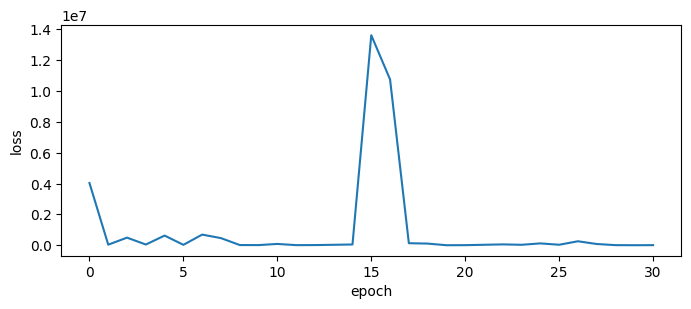

In [10]:
plot_loss(model_00)

No caso do modelo inicial a performance apresentada não é suficiente e mudanças significativas são necessárias.

Para melhorar:
- Lenta progressão de aprendizado - `learning_rate_inits = 1`
- Lenta execução - `batch_size = 10`

Dessa forma a rede neural passa a utilizar o método de atualização dos pesos *Mini Batch* ao invés de *Stochastic Gradient Descent*.

time_to_fit:  9.478915214538574
{'accuracy': 0.1, 'best_loss': 312.59906251017355}


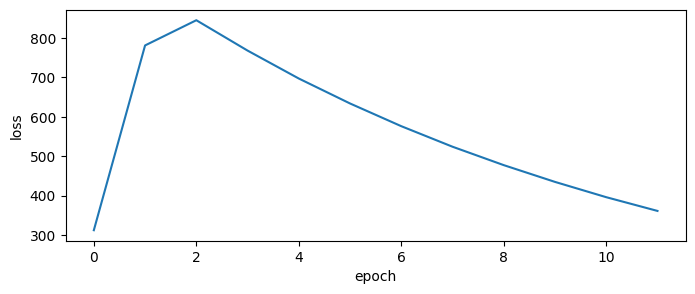

In [11]:
model_01 = MLPClassifier(
    activation = 'tanh',
    hidden_layer_sizes=100,
    solver = 'sgd',
    batch_size=10,
    learning_rate='constant',
    learning_rate_init=1,
)

st = time()
model_01.fit(features, target)
time_to_fit = time() - st

print('time_to_fit: ', time_to_fit)
print_metrics(model_01)
plot_loss(model_01)

Nota-se que o modelo já apresenta execução mais rápida, a métrica de *loss* apresenta redução significativa, mas a acurácia no dado de treino permanece baixa.

Para melhorar o resultado da acurácia baixa e da *loss* alta uma opção seria de aumentar o `batch_size` para reduzir o número de atualizações de erro e tornar a evolução de *loss* das épocas mais suave. Nota-se que a curva de *loss* por época varia com valores muito altos e apresenta passos longos também.

In [12]:
results_batch_size = list()
batch_sizes = [10, 50, 100, 200, 500, 1000, 3000, 5000]

for batch_size, _ in tqdm(list(product(batch_sizes, range(3)))):
    model_ = MLPClassifier(
        activation = 'tanh',
        hidden_layer_sizes=100,
        solver = 'sgd',
        batch_size=batch_size,
        learning_rate='constant',
        learning_rate_init=1,
    )

    st = time()
    model_.fit(features, target)
    time_to_fit = time() - st

    results_batch_size.append({
        'batch_size': batch_size,
        'time_to_fit': time_to_fit,
        'accuracy': accuracy_score(
            y_pred=model_.predict(features),
            y_true=target,
        ),
        'best_loss': model_.best_loss_,
    })

24it [02:38,  6.61s/it]


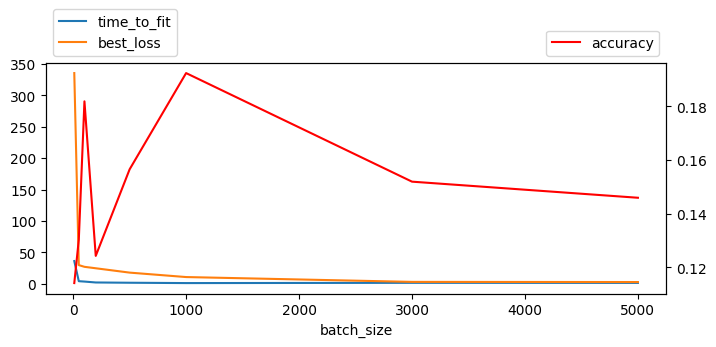

In [14]:
df = (
    pd.DataFrame(results_batch_size)
    .groupby('batch_size', as_index=False)
    .agg({
        'time_to_fit': 'mean',
        'best_loss': 'mean',
        'accuracy': 'mean',
    })
)

plt.figure(figsize=(8, 3))
ax = plt.gca()
df.plot(x='batch_size', y=['time_to_fit', 'best_loss'], ax=ax)
axt = ax.twinx()
df.plot(x='batch_size', y=['accuracy'], ax=axt, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
axt.legend(loc='lower right', bbox_to_anchor=(1, 1))
plt.show()
plt.close()

Ao testar múltiplos valores para `batch_size` nota-se que para esse problema, exceto pela acurácia, quanto maior o `batch_size` melhores as métricas de tempo para ajuste e *loss*. Desse modo pode-se considerar que o melhor valor para o parâmetro de `batch_size` é aquele que representa o método de aprendizado *Gradient Descent* considerando todo o conjunto de dados para atualizar o peso da *epoch*.

Como forma de melhorar o valor de acurácia no dado de teste, experimentos com diferentes quantidades de neurônios na camada escondida podem ser feitos. Quanto maior a quantidade de neurônios maior a complexidade do modelo e maior a quantidade de dados necessária para obter um bom ajuste.

In [19]:
results_hidden_size = list()
hidden_sizes = [25, 50, 75, 100]

for hidden_size, _ in tqdm(list(product(hidden_sizes, range(5)))):
    model_ = MLPClassifier(
        activation = 'tanh',
        hidden_layer_sizes=hidden_size,
        solver = 'sgd',
        batch_size=features.shape[0],
        learning_rate='constant',
        learning_rate_init=1,
    )

    st = time()
    model_.fit(features, target)
    time_to_fit = time() - st

    results_hidden_size.append({
        'hidden_size': hidden_size,
        'time_to_fit': time_to_fit,
        'accuracy': accuracy_score(
            y_pred=model_.predict(features),
            y_true=target,
        ),
        'best_loss': model_.best_loss_,
    })

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


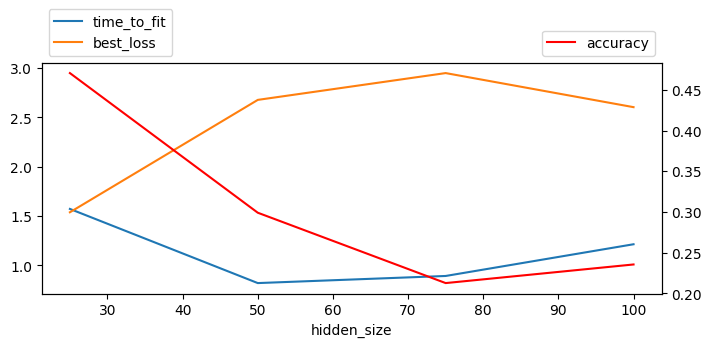

In [20]:
df = (
    pd.DataFrame(results_hidden_size)
    .groupby('hidden_size', as_index=False)
    .agg({
        'time_to_fit': 'mean',
        'best_loss': 'mean',
        'accuracy': 'mean',
    })
)

plt.figure(figsize=(8, 3))
ax = plt.gca()
df.plot(x='hidden_size', y=['time_to_fit', 'best_loss'], ax=ax)
axt = ax.twinx()
df.plot(x='hidden_size', y=['accuracy'], ax=axt, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
axt.legend(loc='lower right', bbox_to_anchor=(1, 1))
plt.show()
plt.close()

Ao testar múltiplos valores para `hidden_layer_sizes` nota-se que para esse problema,  quanto maior o `hidden_layer_sizes` melhores as métricas de performance avaliadas. Desse modo pode-se considerar que o melhor valor para o parâmetro de `hidden_layer_sizes` é de 100 dentre os valores sugeridos para o problema.

100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


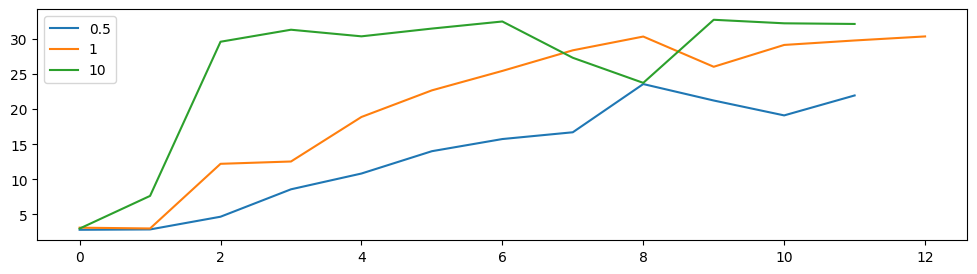

In [39]:
plt.figure(figsize=(12, 3))
learning_rates = [0.5, 1, 10]

for learning_rate in tqdm(learning_rates):
    model_ = MLPClassifier(
        activation = 'tanh',
        hidden_layer_sizes=100,
        solver = 'sgd',
        batch_size=features.shape[0],
        learning_rate='constant',
        learning_rate_init=learning_rate,
    )

    st = time()
    model_.fit(features, target)
    time_to_fit = time() - st

    plt.plot(model_.loss_curve_, label=learning_rate)

plt.legend()
plt.show()
plt.close()

Nota-se que apesar dos bons valores encontrados nos experimentos anteriores o comportamento de atualização do modelo a cada *epoch* atualiza os pesos do modelo de forma brusca o suficiente para reduzir a qualidade do modelo quanto maior a quantidade de atualizações. Usualmente isso é resultado de valores de taxa de aprendizado muito elevadas e o método de correção é reduzir para valores menores.

Como o menor valor sugerido de taxa de aprendizado (0.5) ainda é um valor muito elevado, valores menores serão testados nesse modelo para avaliar a possibilidade de encontrar melhores resultados.

Para evitar problemas com `ConvergenceWarning` o número máximo de *epochs* controlado pelo parâmetro `max_iter` será alterado de 200 (valor *default*) para 500.

100%|██████████| 4/4 [00:58<00:00, 14.59s/it]


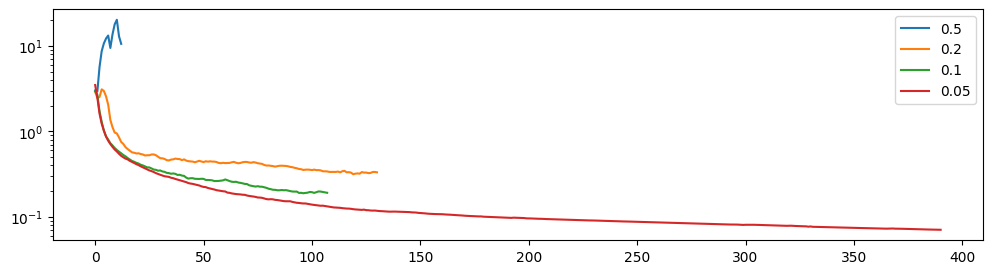

In [42]:
plt.figure(figsize=(12, 3))
results_learning_rates = list()
learning_rates = [0.5, 0.2, 0.1, 0.05]

for learning_rate in tqdm(learning_rates):
    model_ = MLPClassifier(
        activation = 'tanh',
        hidden_layer_sizes=100,
        solver = 'sgd',
        batch_size=features.shape[0],
        learning_rate='constant',
        learning_rate_init=learning_rate,
        max_iter=500,
    )

    st = time()
    model_.fit(features, target)
    time_to_fit = time() - st

    plt.plot(model_.loss_curve_, label=learning_rate)

    results_learning_rates.append({
        'learning_rate': learning_rate,
        'time_to_fit': time_to_fit,
        'accuracy': accuracy_score(
            y_pred=model_.predict(features),
            y_true=target,
        ),
        'best_loss': model_.best_loss_,
    })

plt.yscale('log')
plt.legend()
plt.show()
plt.close()

Com taxas de aprendizado menores o comportamento do aprendizado do modelo se torna mais suave e a capacidade de atualizar os pesos na direção correta não é perdida como no caso e que a taxa de aprendizado é alta.

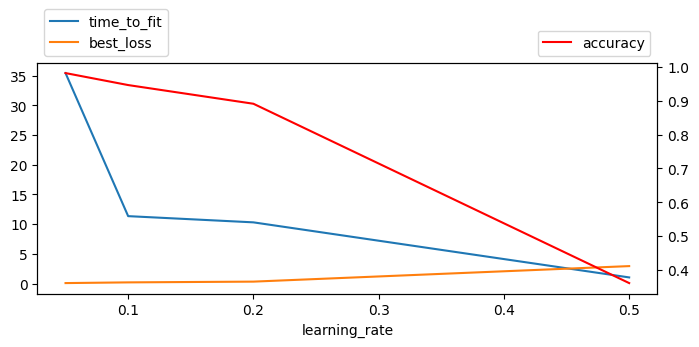

In [44]:
df = (
    pd.DataFrame(results_learning_rates)
    .groupby('learning_rate', as_index=False)
    .agg({
        'time_to_fit': 'mean',
        'best_loss': 'mean',
        'accuracy': 'mean',
    })
)

plt.figure(figsize=(8, 3))
ax = plt.gca()
df.plot(x='learning_rate', y=['time_to_fit', 'best_loss'], ax=ax)
axt = ax.twinx()
df.plot(x='learning_rate', y=['accuracy'], ax=axt, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
axt.legend(loc='lower right', bbox_to_anchor=(1, 1))
plt.show()
plt.close()

Além do melhor comportamento da *loss*, os modelos avaliados com menor taxa de aprendizado apresentam métricas de performance melhores, exceto pelo tempo de execução. Entretando, para alcançar um resultado de acurácia consideravelmente maior, é válido manter um modelo com maior tempo de treinamento.

Para avaliar a qualidade do modelo final encontrado e garantir que o comportamento não foi puramente aleatório, múltiplas execuções serão feitas para avaliar a qualidade da performance do modelo.

100%|██████████| 20/20 [13:26<00:00, 40.35s/it]


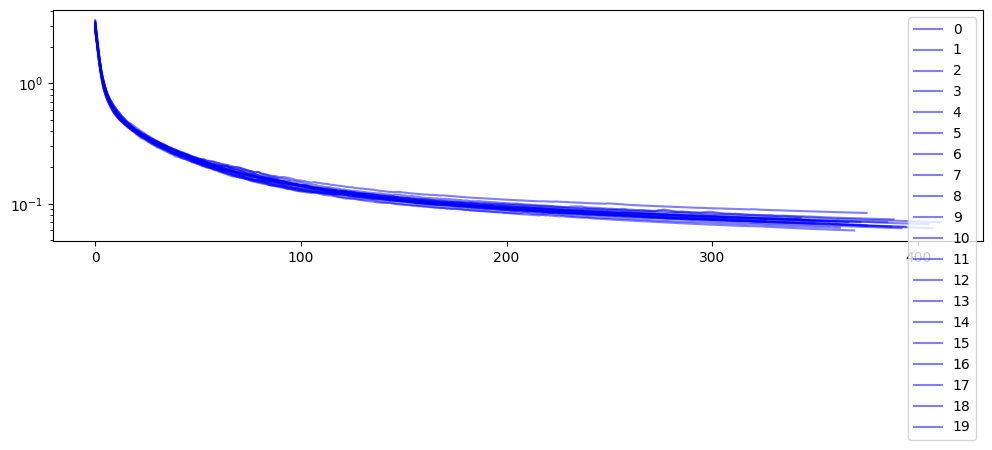

In [45]:
plt.figure(figsize=(12, 3))
results_final = list()

for learning_rate in tqdm(range(20)):
    model_ = MLPClassifier(
        activation = 'tanh',
        hidden_layer_sizes=100,
        solver = 'sgd',
        batch_size=features.shape[0],
        learning_rate='constant',
        learning_rate_init=0.05,
        max_iter=500,
    )

    st = time()
    model_.fit(features, target)
    time_to_fit = time() - st

    plt.plot(model_.loss_curve_, label=learning_rate, color='blue', alpha=.5)

    results_final.append({
        'time_to_fit': time_to_fit,
        'accuracy': accuracy_score(
            y_pred=model_.predict(features),
            y_true=target,
        ),
        'best_loss': model_.best_loss_,
    })

plt.yscale('log')
plt.show()
plt.close()

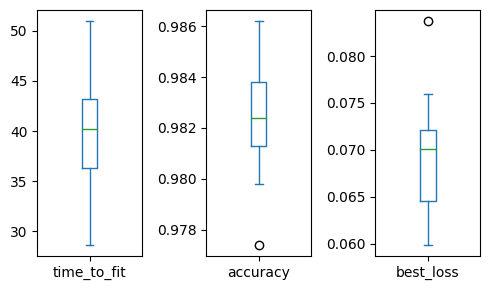

In [58]:
df = pd.DataFrame(results_final)

fig, ax = plt.subplots(1, 3, figsize=(5, 3))
df['time_to_fit'].plot.box(ax=ax[0])
df['accuracy'].plot.box(ax=ax[1])
df['best_loss'].plot.box(ax=ax[2])

plt.tight_layout()
plt.show()
plt.close()

Nota-se que os hiper-parâmetros esolhidos para o modelo apresentam resultados muito bons para a avaliação no dado de treinamento. Como forma de validar a performance do modelo com melhora qualidade e mensurar a capacidade de generalização do modelo o dado inicial será separado em dados de treinamento e dados de teste.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4500, 784), (500, 784), (4500,), (500,))

In [66]:
model_ = MLPClassifier(
    activation = 'tanh',
    hidden_layer_sizes=100,
    solver = 'sgd',
    batch_size=X_train.shape[0],
    learning_rate='constant',
    learning_rate_init=0.05,
    max_iter=500,
)

model_.fit(X_train, y_train)
print(classification_report(
    y_true=y_test,
    y_pred=model_.predict(X_test)
))

/home/maia/UFMG/202301-UFMG-DCCML/TP1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.98      0.98        51
           1       0.92      0.96      0.94        51
           2       0.96      0.94      0.95        53
           3       0.80      0.89      0.85        46
           4       0.92      0.88      0.90        52
           5       0.84      0.80      0.82        46
           6       0.94      0.98      0.96        52
           7       0.96      0.91      0.93        53
           8       0.85      0.81      0.83        42
           9       0.85      0.87      0.86        54

    accuracy                           0.91       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.91      0.91      0.91       500



---